In [58]:
import pandas as pd
import numpy as np
from itertools import count

In [59]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
csv_path = '/content/drive/MyDrive/retailrocket/filtered_sessions.csv'
data = pd.read_csv(csv_path)
data.head()

,timestamp,visitorid,event,itemid,category,global_session_id,interaction_type_id,time_since_last_interaction_logscaled,item_preference_logscaled,item_popularity_logscaled,time_since_session_start_logscaled,session_duration_logscaled
0,2015-09-11 20:49:49.439,0,view,285930,1188,0:START:20150911204949:DUR:00327s,3,0.189860,0.080446,0.229065,0.289316,0.468937
1,2015-09-11 20:52:39.591,0,view,357564,256,0:START:20150911204949:DUR:00327s,3,0.000000,0.000000,0.883486,0.000000,0.000000
2,2015-09-11 20:55:17.175,0,view,67045,333,0:START:20150911204949:DUR:00327s,3,0.000000,0.000000,0.738648,0.000000,0.000000
3,2015-08-07 17:51:44.567,2,view,325215,299,2:START:20150807175144:DUR:01753s,3,0.244409,0.298417,0.684853,0.657039,0.677851
4,2015-08-07 17:53:33.790,2,view,325215,299,2:START:20150807175144:DUR:01753s,3,0.000000,0.000000,0.287558,0.000000,0.000000


In [62]:
csv_path2 = '/content/drive/MyDrive/retailrocket/final_generated_data.csv'
rnn_generated_data = pd.read_csv(csv_path2)
rnn_generated_data.head()

,Unnamed: 0,UserID,ItemID,InteractionType,Timestamp
0,0,772752,228644,3,2015-05-19 03:50:37.559
1,1,772752,422356,3,2015-05-19 03:53:15.559
2,2,772752,122604,3,2015-05-19 03:55:43.559
3,3,772752,312728,3,2015-05-19 03:58:11.559
4,4,801046,333583,3,2015-06-23 01:01:52.413


In [67]:
data.rename(columns={'itemid': 'ItemID'}, inplace=True)

In [68]:
data.rename(columns={'category': 'CategoryID'}, inplace=True)

In [69]:
from sklearn.preprocessing import LabelEncoder

# sort DataFrame
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.sort_values(by=['visitorid', 'timestamp'], inplace=True)

# encode items
item_types = data['ItemID'].unique().tolist()
item_encoder = LabelEncoder()
item_encoder.fit(item_types)

data['itemid_encoded'] = item_encoder.transform(data['ItemID'])

# encode interactions
interaction_types = data['interaction_type_id'].unique().tolist()
interaction_encoder = LabelEncoder()
interaction_encoder.fit(interaction_types)


data['interaction_type_encoded'] = interaction_encoder.transform(data['interaction_type_id'])

In [70]:
# function to generated data using dirichlet distribution
def generate_data_using_dirichlet(user_ids, data, num_predictions_per_user=None):
    # Get the distribution of interaction types and item IDs in the original data
    interaction_counts = data['interaction_type_encoded'].value_counts()
    item_counts = data['itemid_encoded'].value_counts()

    interactions = interaction_counts.index
    items = item_counts.index

    # Using the frequency of each interaction type and item ID as alpha parameters
    interaction_alpha_params = interaction_counts.values
    item_alpha_params = item_counts.values

    user_ids_list, item_list, interactions_list = [], [], []

    for user_id in user_ids:
        num_predictions = num_predictions_per_user.get(user_id, np.random.randint(2, 20))
        # Sample from Dirichlet distribution for interaction types and items
        interaction_probabilities = np.random.dirichlet(interaction_alpha_params)
        item_probabilities = np.random.dirichlet(item_alpha_params)

        sampled_interactions_encoded = np.random.choice(interactions, size=num_predictions, p=interaction_probabilities)
        sampled_items_encoded = np.random.choice(items, size=num_predictions, p=item_probabilities)

        # Decode sampled data
        sampled_interactions = interaction_encoder.inverse_transform(sampled_interactions_encoded)
        sampled_items = item_encoder.inverse_transform(sampled_items_encoded)

        # Populate the lists for each generated attribute
        for i in range(num_predictions):
            user_ids_list.append(user_id)
            interactions_list.append(sampled_interactions[i])
            item_list.append(sampled_items[i])

    return user_ids_list, interactions_list, item_list


In [72]:
# get userids in RNN data
unique_user_ids = rnn_generated_data['UserID'].unique()

# Generate data for the user IDs
num_predictions_per_user = {user_id: np.random.randint(2, 20) for user_id in unique_user_ids}
user_ids_output, interactions_output, item_output = generate_data_using_dirichlet(unique_user_ids, data, num_predictions_per_user)

# Create a DataFrame from the generated data
generated_data_dirichlet = pd.DataFrame({
    'UserID': user_ids_output,
    'InteractionType': interactions_output,
    'ItemID': item_output,

})

# Display or save the output
print(generated_data_dirichlet.head())


   UserID  InteractionType  ItemID
0  772752                3  189764
1  772752                3  326803
2  801046                3  170241
3  801046                3   29642
4  801046                3  228287


In [73]:
generated_data_dirichlet.head()

,UserID,InteractionType,ItemID
0,772752,3,189764
1,772752,3,326803
2,801046,3,170241
3,801046,3,29642
4,801046,3,228287


In [74]:
len(generated_data_dirichlet)


10315

In [75]:
userIDS = generated_data_dirichlet['UserID'].unique()
len(userIDS)


995

In [76]:
itemIDS = generated_data_dirichlet['ItemID'].unique()
len(itemIDS)

8115

In [77]:
data.rename(columns={'interaction_type_id': 'InteractionType'}, inplace=True)
data.rename(columns={'visitorid': 'UserID'}, inplace=True)
data.rename(columns={'itemid': 'ItemID'}, inplace=True)

In [78]:
# Assuming `data` includes 'ItemID', 'CategoryID', and 'timestamp'
# Sort by 'ItemID' and 'timestamp' so that the most recent category appears last for each item
item_to_category_sorted = data.sort_values(by=['ItemID', 'timestamp'], ascending=[True, False])

# Drop duplicates, keeping the last occurrence which due to our sort will have the most recent category
item_to_category_map = item_to_category_sorted.drop_duplicates(subset='ItemID', keep='last')

# Now item_to_category_map has each ItemID with its most recent CategoryID
print(item_to_category_map[['ItemID', 'CategoryID']])


        ItemID   CategoryID
248064       3         1171
222202       6         1091
661729      15          722
252606      16          333
569619      17         1265
...        ...          ...
626576  466849          464
329529  466857          242
245484  466860  no_category
525238  466861         1051
843794  466864          373

[98136 rows x 2 columns]


In [79]:
# Apply the mapping
rnn_generated_data['CategoryID'] = rnn_generated_data['ItemID'].map(item_to_category_map.set_index('ItemID')['CategoryID'])
generated_data_dirichlet['CategoryID'] = generated_data_dirichlet['ItemID'].map(item_to_category_map.set_index('ItemID')['CategoryID'])
rnn_generated_data.head()


,Unnamed: 0,UserID,ItemID,InteractionType,Timestamp,CategoryID
0,0,772752,228644,3,2015-05-19 03:50:37.559,1051
1,1,772752,422356,3,2015-05-19 03:53:15.559,1051
2,2,772752,122604,3,2015-05-19 03:55:43.559,1483
3,3,772752,312728,3,2015-05-19 03:58:11.559,1098
4,4,801046,333583,3,2015-06-23 01:01:52.413,445


In [80]:
# Extract unique item IDs from the generated datasets
rnn_generated_item_ids = set(rnn_generated_data['ItemID'].unique())
dirichlet_generated_item_ids = set(generated_data_dirichlet['ItemID'].unique())


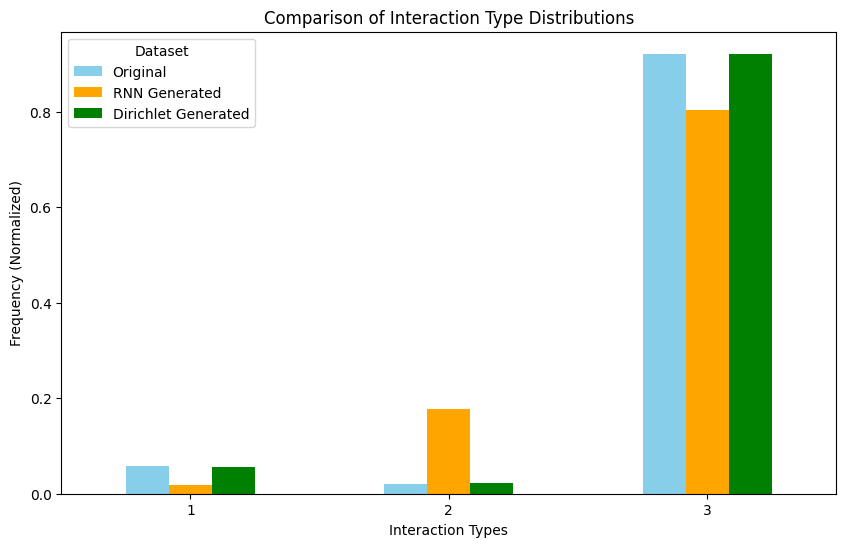

In [81]:
import pandas as pd
import matplotlib.pyplot as plt

def get_normalized_counts(df, column):
    return df[column].value_counts(normalize=True).sort_index()

# Get normalized counts for interaction types
original_counts = get_normalized_counts(data, 'InteractionType')
rnn_counts = get_normalized_counts(rnn_generated_data, 'InteractionType')
dirichlet_counts = get_normalized_counts(generated_data_dirichlet, 'InteractionType')

# Create a DataFrame for plotting
comparison_df = pd.DataFrame({
    'Original': original_counts,
    'RNN Generated': rnn_counts,
    'Dirichlet Generated': dirichlet_counts
})

# Plotting
comparison_df.plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange', 'green'])
plt.title('Comparison of Interaction Type Distributions')
plt.xlabel('Interaction Types')
plt.ylabel('Frequency (Normalized)')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability if necessary
plt.legend(title='Dataset')
plt.show()


In [82]:
import pandas as pd

#  original_counts, rnn_counts, and dirichlet_counts are Series objects
# with interaction types as indexes
summary_table = pd.DataFrame({
    'Original': original_counts,
    'RNN Generated': rnn_counts,
    'Dirichlet Generated': dirichlet_counts
})

# Fill NaN values with 0 if any, because not all datasets may have all interaction types
summary_table.fillna(0, inplace=True)

# Display the table
print(summary_table)


                 Original  RNN Generated  Dirichlet Generated
InteractionType                                              
1                0.057591       0.018491             0.056617
2                0.020884       0.176793             0.021813
3                0.921525       0.804716             0.921571


In [83]:
from scipy.stats import entropy

def calculate_probability_distribution(df, column):
    """ Calculate normalized probability distribution for the specified column in a DataFrame. """
    counts = df[column].value_counts()
    total = counts.sum()
    probabilities = counts / total
    return probabilities

# Calculate distributions
original_prob = calculate_probability_distribution(data, 'InteractionType').reindex(index=comparison_df.index, fill_value=0)
rnn_prob = calculate_probability_distribution(rnn_generated_data, 'InteractionType').reindex(index=comparison_df.index, fill_value=0)
dirichlet_prob = calculate_probability_distribution(generated_data_dirichlet, 'InteractionType').reindex(index=comparison_df.index, fill_value=0)

In [84]:
# Calculate KL divergence from original to RNN generated data
kl_divergence_rnn = entropy(original_prob, rnn_prob)

# Calculate KL divergence from original to Dirichlet generated data
kl_divergence_dirichlet = entropy(original_prob, dirichlet_prob)

print(f"KL Divergence from Original to RNN Generated Data: {kl_divergence_rnn}")
print(f"KL Divergence from Original to Dirichlet Generated Data: {kl_divergence_dirichlet}")


KL Divergence from Original to RNN Generated Data: 0.1453322461582247
KL Divergence from Original to Dirichlet Generated Data: 0.0008218830302402988


# Item Model

In [85]:

# Filter the original dataset to only include rows with item IDs that are in the generated datasets
filtered_data_rnn = data[data['ItemID'].isin(rnn_generated_item_ids)]
filtered_data_dirichlet = data[data['ItemID'].isin(dirichlet_generated_item_ids)]

In [86]:
import pandas as pd
import numpy as np
from scipy.stats import entropy

def calculate_probability_distribution_item(df, column, index):
    """ Calculate normalized probability distribution for the specified column in a DataFrame. """
    counts = df[column].value_counts()
    probabilities = counts.reindex(index=index, fill_value=0)
    total = probabilities.sum()
    probabilities /= total
    return probabilities


rnn_item_ids = filtered_data_rnn['ItemID']
dirichlet_item_ids = filtered_data_dirichlet['ItemID']
# Calculate distributions
original_prob_rnn = calculate_probability_distribution_item(filtered_data_rnn, 'ItemID', rnn_item_ids)
original_prob_dirichlet = calculate_probability_distribution_item(filtered_data_dirichlet, 'ItemID', dirichlet_item_ids)
rnn_prob = calculate_probability_distribution_item(rnn_generated_data, 'ItemID', rnn_item_ids)
dirichlet_prob = calculate_probability_distribution_item(generated_data_dirichlet, 'ItemID', dirichlet_item_ids)


In [87]:
# Calculate KL divergence from original to RNN generated data
kl_divergence_rnn = entropy(original_prob_rnn, rnn_prob)

# Calculate KL divergence from original to Dirichlet generated data
kl_divergence_dirichlet = entropy(original_prob_dirichlet, dirichlet_prob)

print(f"KL Divergence from Original to RNN Generated Data for items: {kl_divergence_rnn}")
print(f"KL Divergence from Original to Dirichlet Generated for items: {kl_divergence_dirichlet}")


KL Divergence from Original to RNN Generated Data for items: 0.8147497092101856
KL Divergence from Original to Dirichlet Generated for items: 0.18339773541424198


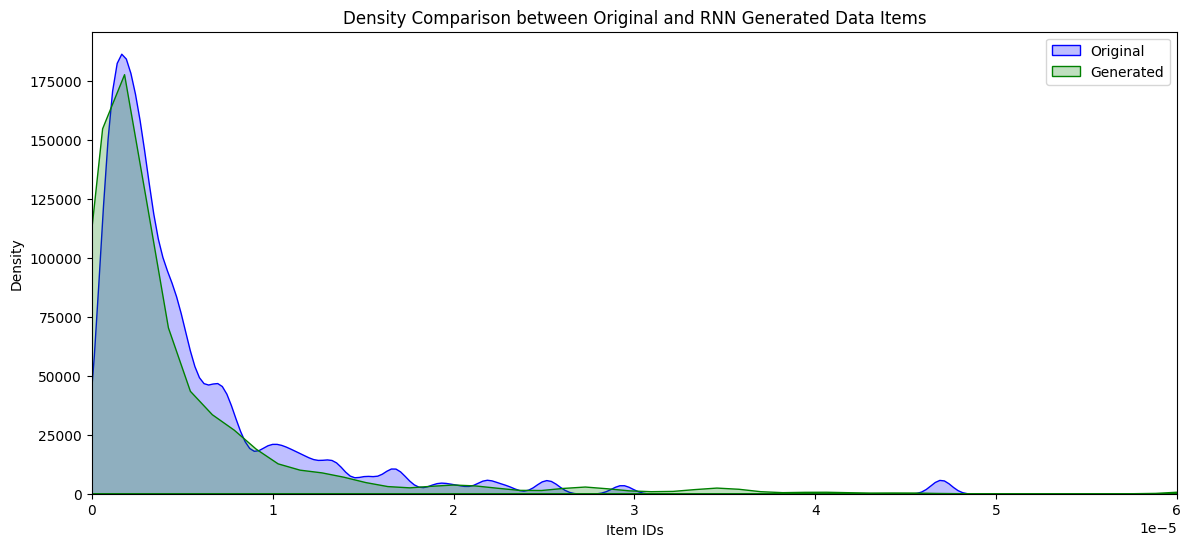

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_density(original, generated, title, xlabel , xlim=None):
    plt.figure(figsize=(14, 6))
    sns.kdeplot(original, label='Original', color='blue', fill=True, common_norm=False)
    sns.kdeplot(generated, label='Generated', color='green', fill=True, common_norm=False)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Density')
    plt.legend()
    if xlim:
        plt.xlim(xlim)  # Apply xlim if specified
    plt.show()

# Call the function with appropriate probability series and xlim values
plot_density(original_prob_rnn, rnn_prob, "Density Comparison between Original and RNN Generated Data Items",xlabel="Item IDs" , xlim=(0, 0.00006))


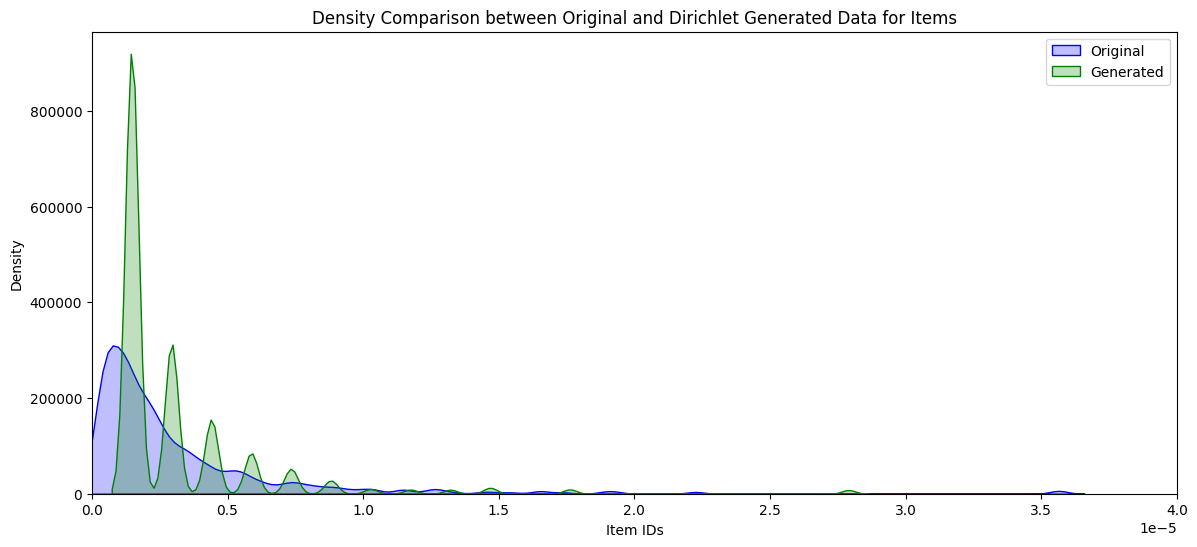

In [114]:
plot_density(original_prob_dirichlet, dirichlet_prob, "Density Comparison between Original and Dirichlet Generated Data for Items",xlabel="Item IDs", xlim=(0, 0.00004))

In [90]:
# Extracting all possible ItemIDs from the original data
rnn_category_ids = rnn_generated_data['CategoryID']
dirichlet_category_ids = generated_data_dirichlet['CategoryID']
# Calculate distributions
original_prob_rnn_cat = calculate_probability_distribution_item(filtered_data_rnn, 'CategoryID', rnn_category_ids)

original_prob_dirichlet_cat = calculate_probability_distribution_item(filtered_data_dirichlet, 'CategoryID', dirichlet_category_ids)
rnn_prob_cat = calculate_probability_distribution_item(rnn_generated_data, 'CategoryID', rnn_category_ids)
dirichlet_prob_cat = calculate_probability_distribution_item(generated_data_dirichlet, 'CategoryID', dirichlet_category_ids)

In [91]:
# Calculate KL divergence from original to RNN generated data
kl_divergence_rnn_cat = entropy(original_prob_rnn_cat, rnn_prob_cat)

# Calculate KL divergence from original to Dirichlet generated data
kl_divergence_dirichlet_cat = entropy(original_prob_dirichlet_cat, dirichlet_prob_cat)

print(f"KL Divergence from Original to RNN Generated Data for categories: {kl_divergence_rnn_cat}")
print(f"KL Divergence from Original to Dirichlet Generated Data for categories: {kl_divergence_dirichlet_cat}")

KL Divergence from Original to RNN Generated Data for categories: 0.7366438915841744
KL Divergence from Original to Dirichlet Generated Data for categories: 0.10146846465266048


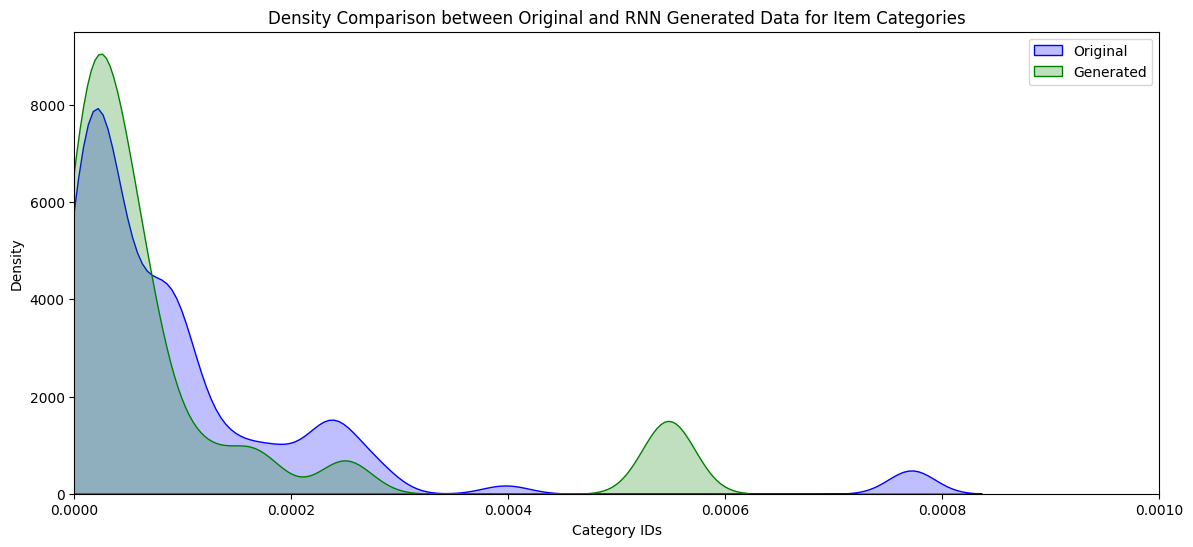

In [92]:
# Call the function with appropriate probability series
plot_density(original_prob_rnn_cat, rnn_prob_cat, "Density Comparison between Original and RNN Generated Data for Item Categories", xlabel="Category IDs", xlim=(0, 0.001))


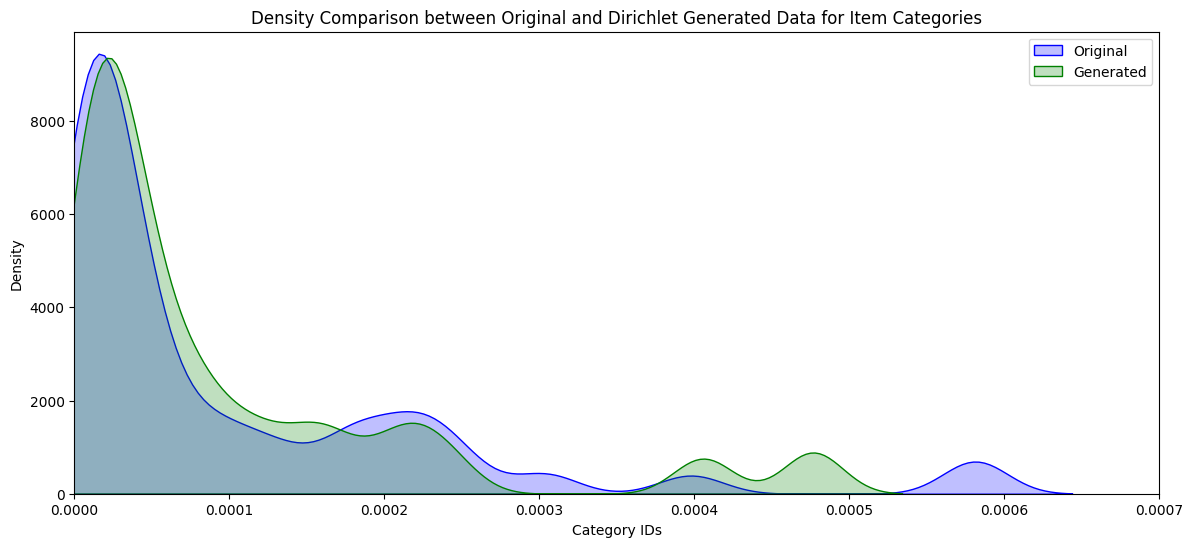

In [93]:
plot_density(original_prob_dirichlet_cat, dirichlet_prob_cat, "Density Comparison between Original and Dirichlet Generated Data for Item Categories",xlabel="Category IDs",  xlim=(0, 0.0007))

<ipython-input-110-38c388838b99>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['CategoryID'] = original['CategoryID'].astype('category')


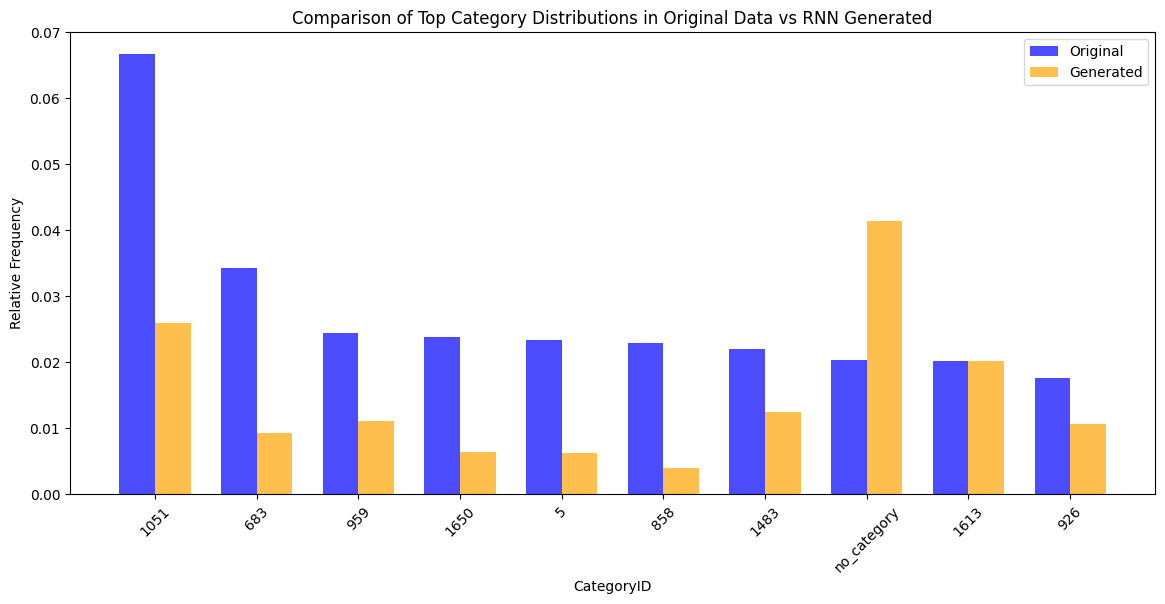

In [110]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_topk_original_histograms(original, generated,title, top_k=20):
    plt.figure(figsize=(14, 6))

    # Convert CategoryID to categorical type if they are not already
    original['CategoryID'] = original['CategoryID'].astype('category')
    generated['CategoryID'] = generated['CategoryID'].astype('category')

    # Get the counts of each category and calculate relative frequencies
    original_counts = original['CategoryID'].value_counts(normalize=True)
    generated_counts = generated['CategoryID'].value_counts(normalize=True)

    # Identify the top categories in the original dataset
    top_original = original_counts.nlargest(top_k)

    # Reindex the generated series to include only the top categories from the original
    generated_top = generated_counts.reindex(top_original.index, fill_value=0)

    # Create bar plots
    categories = top_original.index.tolist()
    x = range(len(categories))
    width = 0.35  # Width of the bars

    plt.bar(x, top_original, width=width, alpha=0.7, label='Original', color='blue', align='center')
    plt.bar([p + width for p in x], generated_top, width=width, alpha=0.7, label='Generated', color='orange', align='center')

    plt.xlabel('CategoryID')
    plt.ylabel('Relative Frequency')
    plt.title(title)
    plt.xticks([p + width / 2 for p in x], categories, rotation=45)  # Rotate category labels for better visibility
    plt.legend()
    plt.show()

# Example usage
plot_topk_original_histograms(filtered_data_rnn, rnn_generated_data,"Comparison of Top Category Distributions in Original Data vs RNN Generated" , top_k=10)


<ipython-input-110-38c388838b99>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['CategoryID'] = original['CategoryID'].astype('category')


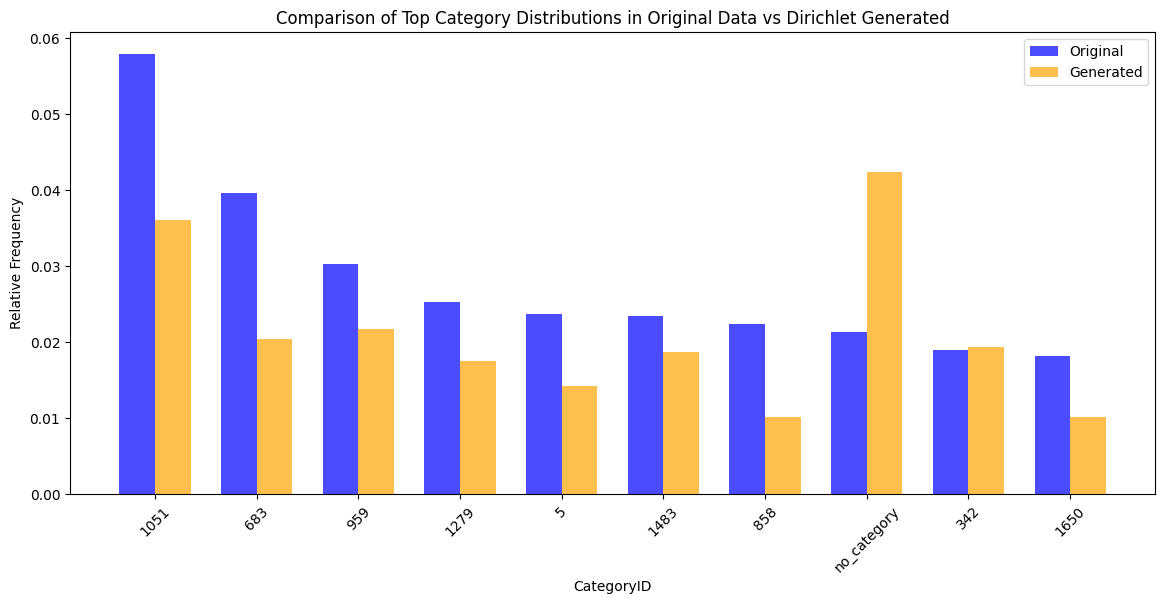

In [111]:
# Example usage
plot_topk_original_histograms(filtered_data_dirichlet, generated_data_dirichlet,"Comparison of Top Category Distributions in Original Data vs Dirichlet Generated" , top_k=10)

In [95]:
# Assume the following dataframes: data, rnn_generated_data, dirichlet_generated_data
# Also assume the item ID column in each is uniformly named 'ItemID'. If not, adjust column names accordingly.

original_unique_items = data['ItemID'].nunique()
rnn_generated_unique_items = rnn_generated_data['ItemID'].nunique()
dirichlet_generated_unique_items = generated_data_dirichlet['ItemID'].nunique()

print("Unique Item IDs in Original Data:", original_unique_items)
print("Unique Item IDs in RNN Generated Data:", rnn_generated_unique_items)
print("Unique Item IDs in Dirichlet Generated Data:", dirichlet_generated_unique_items)


Unique Item IDs in Original Data: 9742
Unique Item IDs in RNN Generated Data: 2762
Unique Item IDs in Dirichlet Generated Data: 8115


In [96]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp

# Assuming original_data and generated_data are pandas Series of item IDs
original_counts = filtered_data_rnn["ItemID"].value_counts(normalize=True).sort_index()
generated_counts = rnn_generated_data["ItemID"].value_counts(normalize=True).sort_index()

# Ensuring both series have the same set of item IDs
all_item_ids = np.union1d(original_counts.index, generated_counts.index)
original_counts = original_counts.reindex(all_item_ids, fill_value=0)
generated_counts = generated_counts.reindex(all_item_ids, fill_value=0)

# Convert to cumulative distributions
cdf_original = np.cumsum(original_counts)
cdf_generated = np.cumsum(generated_counts)

# Perform the Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(cdf_original, cdf_generated)

# Output the results
print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("Reject the null hypothesis - suggest the distribution of the two datasets are different")
else:
    print("Fail to reject the null hypothesis - suggest the distribution of the two datasets are not significantly different")


KS Statistic: 0.07422157856625633
P-value: 4.8772432725028e-07
Reject the null hypothesis - suggest the distribution of the two datasets are different


In [97]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp

# Assuming original_data and generated_data are pandas Series of item IDs
original_counts = filtered_data_rnn["CategoryID"].value_counts(normalize=True).sort_index()
generated_counts = rnn_generated_data["CategoryID"].value_counts(normalize=True).sort_index()

# Ensuring both series have the same set of item IDs
all_item_ids = np.union1d(original_counts.index, generated_counts.index)
original_counts = original_counts.reindex(all_item_ids, fill_value=0)
generated_counts = generated_counts.reindex(all_item_ids, fill_value=0)

# Convert to cumulative distributions
cdf_original = np.cumsum(original_counts)
cdf_generated = np.cumsum(generated_counts)

# Perform the Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(cdf_original, cdf_generated)

# Output the results
print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("Reject the null hypothesis - suggest the distribution of the two datasets are different")
else:
    print("Fail to reject the null hypothesis - suggest the distribution of the two datasets are not significantly different")


KS Statistic: 0.11157894736842106
P-value: 0.005371705938018984
Reject the null hypothesis - suggest the distribution of the two datasets are different


In [98]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp

# Assuming original_data and generated_data are pandas Series of item IDs
original_counts = filtered_data_dirichlet["ItemID"].value_counts(normalize=True).sort_index()
generated_counts = generated_data_dirichlet["ItemID"].value_counts(normalize=True).sort_index()

# Ensuring both series have the same set of item IDs
all_item_ids = np.union1d(original_counts.index, generated_counts.index)
original_counts = original_counts.reindex(all_item_ids, fill_value=0)
generated_counts = generated_counts.reindex(all_item_ids, fill_value=0)

# Convert to cumulative distributions
cdf_original = np.cumsum(original_counts)
cdf_generated = np.cumsum(generated_counts)

# Perform the Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(cdf_original, cdf_generated)

# Output the results
print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("Reject the null hypothesis - suggest the distribution of the two datasets are different")
else:
    print("Fail to reject the null hypothesis - suggest the distribution of the two datasets are not significantly different")


KS Statistic: 0.014417744916820702
P-value: 0.3678646308079606
Fail to reject the null hypothesis - suggest the distribution of the two datasets are not significantly different


In [99]:
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp

# Assuming original_data and generated_data are pandas Series of item IDs
original_counts = filtered_data_dirichlet["CategoryID"].value_counts(normalize=True).sort_index()
generated_counts = generated_data_dirichlet["CategoryID"].value_counts(normalize=True).sort_index()

# Ensuring both series have the same set of item IDs
all_item_ids = np.union1d(original_counts.index, generated_counts.index)
original_counts = original_counts.reindex(all_item_ids, fill_value=0)
generated_counts = generated_counts.reindex(all_item_ids, fill_value=0)

# Convert to cumulative distributions
cdf_original = np.cumsum(original_counts)
cdf_generated = np.cumsum(generated_counts)

# Perform the Kolmogorov-Smirnov test
ks_statistic, p_value = ks_2samp(cdf_original, cdf_generated)

# Output the results
print(f"KS Statistic: {ks_statistic}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("Reject the null hypothesis - suggest the distribution of the two datasets are different")
else:
    print("Fail to reject the null hypothesis - suggest the distribution of the two datasets are not significantly different")


KS Statistic: 0.04189944134078212
P-value: 0.556262757343209
Fail to reject the null hypothesis - suggest the distribution of the two datasets are not significantly different


In [100]:
import pandas as pd
from scipy.stats import chi2_contingency

# Calculate frequency counts of each item ID
original_counts = filtered_data_rnn["ItemID"].value_counts()
generated_counts = rnn_generated_data["ItemID"].value_counts()


# Create a DataFrame for a contingency table
contingency_table = pd.DataFrame({
    'Original': original_counts,
    'Generated': generated_counts
})

# Fill missing values with 0 where item IDs do not overlap
contingency_table.fillna(0, inplace=True)

# Ensure the order of indices in both columns is the same for consistency
contingency_table.sort_index(inplace=True)

# Perform the Chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Output the results
print(f"Chi-square Statistic: {chi2_stat}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")
# The expected frequencies, if needed, can be reviewed as follows
print("Expected Frequencies:\n", expected)

# Interpret the results
if p_value < 0.05:
    print("Reject the null hypothesis - There is a significant difference between the distributions.")
else:
    print("Fail to reject the null hypothesis - No significant difference between the distributions.")


Chi-square Statistic: 23809.98037682232
P-value: 0.0
Degrees of Freedom: 2761
Expected Frequencies:
 [[ 37.92811968   2.07188032]
 [ 42.66913464   2.33086536]
 [364.10994892  19.89005108]
 ...
 [  9.48202992   0.51797008]
 [ 10.43023291   0.56976709]
 [ 46.46194661   2.53805339]]
Reject the null hypothesis - There is a significant difference between the distributions.


In [101]:
import pandas as pd
from scipy.stats import chi2_contingency

# Calculate frequency counts of each item ID
original_counts = filtered_data_rnn["CategoryID"].value_counts()
generated_counts = rnn_generated_data["CategoryID"].value_counts()


# Create a DataFrame for a contingency table
contingency_table = pd.DataFrame({
    'Original': original_counts,
    'Generated': generated_counts
})

# Fill missing values with 0 where item IDs do not overlap
contingency_table.fillna(0, inplace=True)

# Ensure the order of indices in both columns is the same for consistency
contingency_table.sort_index(inplace=True)

# Perform the Chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Output the results
print(f"Chi-square Statistic: {chi2_stat}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")
# The expected frequencies, if needed, can be reviewed as follows
print("Expected Frequencies:\n", expected)

# Interpret the results
if p_value < 0.05:
    print("Reject the null hypothesis - There is a significant difference between the distributions.")
else:
    print("Fail to reject the null hypothesis - No significant difference between the distributions.")


Chi-square Statistic: 14016.56031971056
P-value: 0.0
Degrees of Freedom: 474
Expected Frequencies:
 [[1.48867870e+02 8.13213026e+00]
 [5.49957735e+01 3.00422647e+00]
 [6.82706154e+01 3.72938458e+00]
 [1.51712479e+01 8.28752128e-01]
 [1.41282246e+02 7.71775420e+00]
 [5.40475705e+01 2.95242946e+00]
 [5.49957735e+01 3.00422647e+00]
 [5.59439765e+01 3.05602347e+00]
 [3.31871047e+01 1.81289528e+00]
 [2.53170199e+02 1.38298011e+01]
 [1.00509517e+02 5.49048285e+00]
 [5.00651180e+02 2.73488202e+01]
 [2.07656455e+02 1.13435448e+01]
 [1.42230449e+02 7.76955120e+00]
 [1.76365757e+02 9.63424349e+00]
 [2.37050748e+01 1.29492520e+00]
 [2.24913750e+03 1.22862503e+02]
 [1.86795989e+02 1.02040106e+01]
 [2.63600432e+02 1.43995682e+01]
 [9.29238932e+01 5.07610679e+00]
 [4.93065556e+01 2.69344442e+00]
 [3.59368934e+02 1.96310660e+01]
 [1.20848471e+04 6.60152867e+02]
 [9.48202992e+00 5.17970080e-01]
 [4.36173376e+01 2.38266237e+00]
 [1.28007404e+02 6.99259608e+00]
 [1.24214592e+02 6.78540805e+00]
 [1.49816

In [102]:
import pandas as pd
from scipy.stats import chi2_contingency

# Calculate frequency counts of each item ID
original_counts = filtered_data_dirichlet["CategoryID"].value_counts()
generated_counts = generated_data_dirichlet["CategoryID"].value_counts()


# Create a DataFrame for a contingency table
contingency_table = pd.DataFrame({
    'Original': original_counts,
    'Generated': generated_counts
})

# Fill missing values with 0 where item IDs do not overlap
contingency_table.fillna(0, inplace=True)

# Ensure the order of indices in both columns is the same for consistency
contingency_table.sort_index(inplace=True)

# Perform the Chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Output the results
print(f"Chi-square Statistic: {chi2_stat}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")
# The expected frequencies, if needed, can be reviewed as follows
print("Expected Frequencies:\n", expected)

# Interpret the results
if p_value < 0.05:
    print("Reject the null hypothesis - There is a significant difference between the distributions.")
else:
    print("Fail to reject the null hypothesis - No significant difference between the distributions.")


Chi-square Statistic: 4421.6075507217865
P-value: 0.0
Degrees of Freedom: 715
Expected Frequencies:
 [[6.00936980e+01 1.90630198e+00]
 [3.43115631e+02 1.08843694e+01]
 [1.56049764e+02 4.95023578e+00]
 ...
 [1.18248890e+02 3.75111034e+00]
 [1.77373334e+02 5.62666551e+00]
 [7.12498023e+03 2.26019772e+02]]
Reject the null hypothesis - There is a significant difference between the distributions.


In [112]:
import pandas as pd
from scipy.stats import chi2_contingency

# Calculate frequency counts of each item ID
original_counts = filtered_data_dirichlet["ItemID"].value_counts()
generated_counts = generated_data_dirichlet["ItemID"].value_counts()


# Create a DataFrame for a contingency table
contingency_table = pd.DataFrame({
    'Original': original_counts,
    'Generated': generated_counts
})

# Fill missing values with 0 where item IDs do not overlap
contingency_table.fillna(0, inplace=True)

# Ensure the order of indices in both columns is the same for consistency
contingency_table.sort_index(inplace=True)

# Perform the Chi-square test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

# Output the results
print(f"Chi-square Statistic: {chi2_stat}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")
# The expected frequencies, if needed, can be reviewed as follows
print("Expected Frequencies:\n", expected)

# Interpret the results
if p_value < 0.05:
    print("Reject the null hypothesis - There is a significant difference between the distributions.")
else:
    print("Fail to reject the null hypothesis - No significant difference between the distributions.")


Chi-square Statistic: 18466.745051098518
P-value: 0.0
Degrees of Freedom: 8114
Expected Frequencies:
 [[23.26207665  0.73792335]
 [10.66178513  0.33821487]
 [ 4.84626597  0.15373403]
 ...
 [52.33967247  1.66032753]
 [12.60029152  0.39970848]
 [17.44655749  0.55344251]]
Reject the null hypothesis - There is a significant difference between the distributions.
